In [48]:
import math
import itertools
import numpy as np
import random
from dataclasses import dataclass

In [49]:
L = 6
l_h = int(L/2)
J = 2
P = 24

In [50]:
@dataclass(frozen=True)
class AffineFunc:
    a: int
    b: int
    def __post_init__(self):
        if math.gcd(self.a, P) != 1:
            raise ValueError(f"a ({self.a}) must be coprime with P ({P})")

    def f(self, x: int) -> int:
        return (self.a * x + self.b) % P

    def inv(self):
        try:
            a_inv = pow(self.a, -1, P)
        except ValueError:
             raise ValueError("Inverse does not exist")
        b_new = (-1 * a_inv * self.b) % P
        return AffineFunc(a_inv, b_new)

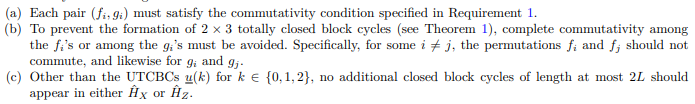

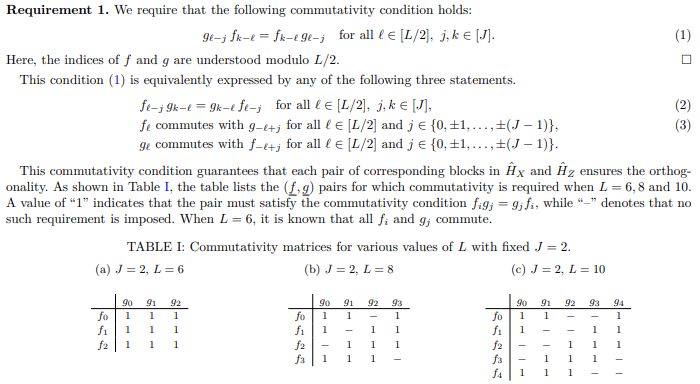

In [51]:
def is_commute(f, g):
    a_1 = f.a
    b_1 = f.b
    a_2 = g.a
    b_2 = g.b
    if ((a_1-1)*b_2 - (a_2-1)*b_1)%P == 0:
        return True
    else:
        return False

In [52]:
def check_req_1(f_list, g_list):
    for i in range(l_h):
        for j in range(-(J-1), J):
            f_idx = i
            g_idx = (-i + j) % l_h
            if not is_commute(f_list[f_idx], g_list[g_idx]):
                return False
    return True
            

In [53]:
def check_inner_commute(f_list):
    flag = False
    for i in range(l_h):
        for j in range(i+1, l_h):
            if  is_commute(f_list[i], f_list[j]) == False:
                flag = True
    return flag

In [54]:
def check_condition_a(f_list, g_list):
    return check_req_1(f_list, g_list)

In [55]:
def check_condition_b(f_list, g_list):
    return check_inner_commute(f_list) and check_inner_commute(g_list)

In [56]:
def make_h_x_functions(f_list, g_list):
    result = []
    for j in range(J):
        row = []
        for l in range(l_h):
            row.append(f_list[(l-j)%l_h])
        for l in range(l_h):
            row.append(g_list[(l-j)%l_h])
        result.append(row)
    return result

In [57]:
def make_h_z_functions(f_list, g_list):
    result = []
    for j in range(J):
        row = []
        for l in range(l_h):
            row.append(g_list[(j-l)%l_h].inv())
        for l in range(l_h):
            row.append(f_list[(j-l)%l_h].inv())
        result.append(row)
    return result

In [58]:
def get_min_list(input):
    input_arr = np.array(input)
    min_result = input_arr.copy()
    for i in range(1, len(input_arr)):
        shifted = np.roll(input_arr, i, axis=0)
        if shifted.tolist() < min_result.tolist():
            min_result = shifted.copy()
    return min_result.tolist()

In [59]:
def make_cols_list():
    result_list = []
    for i in range(1, l_h+1):
        cols_list = [tuple(get_min_list(np.array(p))) for p in itertools.product(range(L), repeat=2*i)]
        result_list.extend(cols_list)
    result_list = list(set(result_list))
    return result_list

In [60]:
def make_cycle(cols, j):
    cycle = []
    print
    for j in range(int(len(cols)/2)):
        cycle.append([j%2, cols[2*j]])
        cycle.append([j%2, cols[2*j+1]])
        cycle.append([(1-j)%2, cols[2*j+1]])
        cycle.append([(1-j)%2, cols[(2*j+2)%len(cols)]])
    return cycle

In [61]:
def composite_affine(left, right):
    a_new = (left.a * right.a) % P
    b_new = (left.a * right.b + left.b) % P
    return AffineFunc(a_new, b_new)

In [62]:
def make_utcbc_list():
    utcbc_list = []
    for k in range(3):
        utcbc_cols = []
        for i in range(l_h):
            utcbc_cols.append(i)
            utcbc_cols.append(l_h + (-i + k)%l_h)
        utcbc_list.append(tuple(get_min_list(utcbc_cols)))
    return utcbc_list

In [63]:
def is_utcbc(cols):
    utcbc_list = make_utcbc_list()
    return cols in utcbc_list

In [ ]:
def check_condition_c(f_list, g_list):
    h_x = make_h_x_functions(f_list, g_list)
    h_z = make_h_z_functions(f_list, g_list)
    cols_list = make_cols_list()
    cbcs = []
    for cols in cols_list:
        flag = True
        if not is_utcbc(cols):
            cycle_function_x = [AffineFunc(1, 0), AffineFunc(1, 0)]
            cycle_function_z = [AffineFunc(1, 0), AffineFunc(1, 0)]
            cycles = [make_cycle(cols, 0), make_cycle(cols, 1)]
            for i in range(int(len(cycles[0])/2)):
                cycle_function_x[0] = composite_affine(cycle_function_x[0], h_x[cycles[0][2*i][0]][cycles[0][2*i][0]])
                cycle_function_x[0] = composite_affine(cycle_function_x[0], h_x[cycles[0][2*i+1][0]][cycles[0][2*i+1][0]].inv())
                cycle_function_x[1] = composite_affine(cycle_function_x[1], h_x[cycles[1][2*i][0]][cycles[1][2*i][0]])
                cycle_function_x[1] = composite_affine(cycle_function_x[1], h_x[cycles[1][2*i+1][0]][cycles[1][2*i+1][0]].inv())
                cycle_function_z[0] = composite_affine(cycle_function_z[0], h_z[cycles[0][2*i][0]][cycles[0][2*i][0]])
                cycle_function_z[0] = composite_affine(cycle_function_z[0], h_z[cycles[0][2*i+1][0]][cycles[0][2*i+1][0]].inv())
                cycle_function_z[1] = composite_affine(cycle_function_z[1], h_z[cycles[1][2*i][0]][cycles[1][2*i][0]])
                cycle_function_z[1] = composite_affine(cycle_function_z[1], h_z[cycles[1][2*i+1][0]][cycles[1][2*i+1][0]].inv())
            for x in range(P):
                if cycle_function_x[0].f(x) == x or cycle_function_x[1].f(x) == x or cycle_function_z[0].f(x) == x or cycle_function_z[1].f(x) == x:
                    flag = False
            if not flag:
                cbcs.append(cols)
    print(cbcs)
    if not cbcs:
        return True

In [65]:
def generate_random_affine_function():
    prime_list = [i for i in range(P) if math.gcd(i,P) == 1]
    a = random.choice(prime_list)
    b = random.choice(range(P))
    return AffineFunc(a, b)

In [66]:
def check_conditions(f_list, g_list):
    if check_condition_a(f_list, g_list) and check_condition_b(f_list, g_list) and check_condition_c(f_list, g_list):
        return True
    return False

最もナイーブな方法(ランダムに生成して、条件を満たすものが見つかるまで探索し続ける)

In [67]:
# count = 0
# while(1):
#     count += 1
#     if count % 1000 == 0:
#         print("count: ", count)
#     f_list = [generate_random_affine_function()]*l_h
#     g_list = [generate_random_affine_function()]*l_h
#     if check_conditions(f_list, g_list):
#         print(f_list, g_list)
#         break

先に$f$のリストを作り、条件(a)の解空間に含まれるものをランダムに生成し、条件(b),(c)を確かめる

In [68]:
def commute_with(f):
    a_1 = f.a
    b_1 = f.b
    candidates = []
    for a_2 in range(0,P):
        if math.gcd(a_2,P)!=1:
            continue
        A = a_1-1
        C = ((a_2-1)*b_1)%P
        d = math.gcd(A, P)
        if a_2==1:
            if a_1==1:
                for i in range(P):
                    b_2 = i
                    candidates.append(AffineFunc(a_2, b_2))
                continue
            else:
                if d==1:
                    b_2 = 0
                    candidates.append(AffineFunc(a_2, b_2))
                    continue
                else:
                    P_prime = int(P/d)
                    for i in range(d):
                        b_2 = i*P_prime
                        candidates.append(AffineFunc(a_2, b_2))
                    continue
        else:
            if a_1==1:
                if C==0:
                    for i in range(P):
                        b_2 = i
                        candidates.append(AffineFunc(a_2, b_2))
                    continue
            else:
                if d==1:
                    b_2 = (pow(A, -1, P) * C)%P
                    candidates.append(AffineFunc(a_2, b_2))
                    continue
                else:
                    if C%d==0:
                        A_prime = int(A/d)
                        P_prime = int(P/d)
                        C_prime = int(C/d)
                        x_0 = (C_prime*pow(A_prime, -1, P_prime))%P_prime
                        for i in range(d):
                            b_2 = x_0+i*P_prime
                            candidates.append(AffineFunc(a_2, b_2))
                        continue
    return candidates

In [ ]:
count = 0
while(1):
    print()
    count += 1
    if count % 1000 == 0:
        print("count: ", count)
    f_list = []
    for _ in range(l_h):
        f_list.append(generate_random_affine_function())
    g_candidates = []
    for i in range(l_h):
        g_candidates.append(commute_with(f_list[i]))
    g_candidates_list = list(set(commute_with(f_list[0]))&set(commute_with(f_list[1]))&set(commute_with(f_list[2])))
    g_list = []
    for _ in range(l_h):
        g_list.append(random.choice(g_candidates_list))
    if check_condition_a(f_list, g_list) and check_condition_b(f_list, g_list):
        print("checking condition c...")
        if check_condition_c(f_list, g_list):
            print(f_list)
            print(g_list)
            break
        

checking condition c...
(0, 1, 3, 5, 3, 3)
(0, 0, 2, 1, 2, 3)
(0, 0, 0, 5, 4, 1)
(1, 5, 4, 5, 5, 3)
(0, 1, 1, 0, 1, 5)
(2, 2, 5, 5, 5, 5)
(0, 1, 4, 1, 0, 5)
(2, 4, 5, 3, 3, 5)
(0, 4, 4, 2, 3, 5)
(0, 0, 1, 0, 3, 3)
(0, 0, 2, 4, 2, 4)
(0, 3, 5, 3, 3, 1)
(0, 5, 5, 1, 1, 1)
(0, 0, 1, 3, 2, 4)
(0, 3, 4, 1, 1, 1)
(1, 1, 2, 2, 1, 4)
(1, 1, 4, 5, 4, 4)
(0, 3, 0, 3, 1, 2)
(0, 5, 4, 4, 3, 5)
(0, 5, 0, 5, 2, 3)
(1, 2, 2, 4, 1, 4)
(1, 2, 4, 1, 4, 3)
(0, 0, 3, 2, 1, 3)
(0, 3, 3, 3, 4, 3)
(1, 4, 3, 2, 2, 5)
(2, 3, 4, 4, 2, 4)
(1, 4, 5, 5, 5, 5)
(2, 4, 5, 2, 5, 3)
(0, 2, 4, 5, 3, 1)
(0, 1, 0, 2, 2, 4)
(1, 3, 3, 5, 5, 3)
(0, 3, 4, 2, 2, 4)
(2, 5, 4, 5, 3, 4)
(0, 3, 0, 4, 2, 5)
(1, 4, 3, 5, 3, 2)
(0, 0, 3, 5, 1, 4)
(0, 2, 1, 3, 0, 4)
(0, 0, 5, 1, 5, 4)
(1, 5, 2, 5, 5, 3)
(1, 1, 3, 3, 4, 3)
(0, 0, 0, 1, 3, 3)
(0, 2, 2, 5, 4, 3)
(0, 1, 5, 4, 4, 3)
(0, 3, 4, 5, 3, 1)
(1, 5, 5, 4, 5, 5)
(0, 5, 3, 1, 4, 2)
(0, 3, 4, 5, 2, 5)
(2, 4, 3, 3, 4, 5)
(0, 0, 5, 0, 2, 2)
(0, 5, 4, 2, 1, 1)
(3, 5)
(0, 2, 0, 3, 0, 5)


KeyboardInterrupt: 

In [ ]:
f_list = [
    AffineFunc(13,18),
    AffineFunc(13,18),
    AffineFunc(19,6),
]
g_list = [
    AffineFunc(17,20),
    AffineFunc(5,0),
    AffineFunc(13,6),
]

False